# Plot qPCR of RNA export by EPN24-MCP and EPN24-PCP

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_PP7_coat_protein"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_PP7_coat_protein_Cq.csv"

cq_raw = pd.read_csv(infile, header=0, index_col=0)

print(cq_raw.shape)
cq_raw.head()

(54, 15)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note
NaN,A06,SYBR,mCherry,Unkn-06,16-29,NaN,33.471920,34.189020,0.756602,3.030884,0.481569,1.999430,0.995582,67,NaN
NaN,A07,SYBR,mCherry,Unkn-07,16-30,NaN,18.806042,18.852837,0.166579,96231.871033,4.983319,93525.256555,10739.291823,67,NaN
NaN,A08,SYBR,mCherry,Unkn-08,16-31,NaN,29.080194,29.002838,0.280118,67.550279,1.829627,72.305241,14.768357,67,NaN
NaN,A09,SYBR,mCherry,Unkn-09,16-32,NaN,27.312801,27.290074,0.219447,235.578423,2.372136,241.331910,37.757720,67,NaN
NaN,A10,SYBR,mCherry,Unkn-10,16-33,NaN,22.285910,22.232567,0.065696,8225.450280,3.915160,8547.668043,400.589543,67,NaN


## Load metadata

In [5]:
infile = "../preprocessed_data/qPCR_data/qPCR_PP7_coat_protein_metadata.csv"

metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()

print(metadata.shape)
metadata.head()

(10, 12)


,Plate,Well,Sample,description,exporter,reporter,xticklabel,xticklabel_simple,color,legend_label,export_tag_plus_or_minus,export_tag
0,2,A06,16-29,No DNA,NaN,NaN,No DNA,No DNA,#969696,No RBD,+,-
1,2,A07,16-30,EPN24-MCP + mCh-MS2x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12,#bdbdbd,No RBD and no packaging signal,-,MS2
2,2,A08,16-31,EPN24-MCP + mCh-PP7x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.214 mCherry-PP7x12,EPN24-MCP + mCh-PP7x12,EPN24-MCP + mCh-PP7x12,#807dba,Exporter and packaging signal,+,PP7
3,2,A09,16-32,EPN24-MCP + mCh,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.1 mCherry,EPN24-MCP + mCh,EPN24-MCP + mCh,#41ab5d,No packaging signal,-,-
4,2,A10,16-33,EPN24-PCP + mCh-MS2x12,pFH2.217 EPN24-PCP-IRES-GFP,pFH2.2 mCherry-MS2x12,EPN24-PCP + mCh-MS2x12,EPN24-PCP + mCh-MS2x12,#807dba,Exporter and packaging signal,+,MS2


## Set sample labels and colors

In [6]:
# Set tick labels
column_to_xticklabel = {"16-29": "No DNA", 
                        "16-30": "EPN24-MCP + mCh-MS2x12",
                        "16-31": "EPN24-MCP + mCh-PP7x12", 
                        "16-32": "EPN24-MCP + mCh",
                        "16-33": "EPN24-PCP + mCh-MS2x12", 
                        "16-34": "EPN24-PCP + mCh-PP7x12",
                        "16-35": "EPN24-PCP + mCh",
                        "16-36": "mCh-MS2x12",
                        "16-37": "mCh-PP7x12", 
                        "16-38": "mCh"}

In [7]:
# Set tick labels
column_to_exporter = {"16-29": "No DNA", 
                        "16-30": "EPN24-MCP",
                        "16-31": "EPN24-MCP",
                        "16-32": "EPN24-MCP",
                        "16-33": "EPN24-PCP",
                        "16-34": "EPN24-PCP",
                        "16-35": "EPN24-PCP",
                        "16-36": "None",
                        "16-37": "None", 
                        "16-38": "None"}

In [8]:
# Set tick labels
column_to_reporter = {"16-29": "No DNA", 
                        "16-30": "mCh-MS2x12",
                        "16-31": "mCh-PP7x12",
                        "16-32": "mCh",
                        "16-33": "mCh-MS2x12",
                        "16-34": "mCh-PP7x12",
                        "16-35": "mCh",
                        "16-36": "mCh-MS2x12",
                        "16-37": "mCh-PP7x12", 
                        "16-38": "mCh"}

In [9]:
# Set export tag
column_to_export_tag = {"16-29": "No DNA", 
                        "16-30": "MS2",
                        "16-31": "PP7",
                        "16-32": "-",
                        "16-33": "MS2",
                        "16-34": "PP7",
                        "16-35": "-",
                        "16-36": "MS2",
                        "16-37": "PP7", 
                        "16-38": "-"}

In [10]:
# Set well colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"

color_no_packaging_signal = "#737373"
color_no_RBD = "#bdbdbd"
color_no_exporter = "#f0f0f0"

color_no_packaging_signal = "#969696"
color_no_RBD = "#d9d9d9"
color_no_exporter = "#525252"

column_to_color = {"16-29": color_no_exporter, 
                        "16-30": color_exporter_engineered,
                        "16-31": color_no_packaging_signal,
                        "16-32": color_no_packaging_signal,
                        "16-33": color_no_packaging_signal,
                        "16-34": color_exporter_engineered,
                        "16-35": color_no_packaging_signal,
                        "16-36": color_no_exporter,
                        "16-37": color_no_exporter,
                        "16-38": color_no_exporter}

In [11]:
# Set legend labels
column_to_label = {"16-29": "No DNA", 
                        "16-30": "Full system",
                        "16-31": "No matched export tag", 
                        "16-32": "No matched export tag", 
                        "16-33": "No matched export tag", 
                        "16-34": "Full system",
                        "16-35": "No matched export tag", 
                        "16-36": "No exporter",
                        "16-37": "No exporter", 
                        "16-38": "No exporter"}

# Preprocess data

## Map samples to metadata

In [12]:
# Merge Cq with metadata, using Sample and Biological Set Name as keys
quant = pd.merge(left=cq_raw, right=metadata, on="Sample")

## Calculate total starting molecules

In [13]:
# Calculate normalization for input volume
DILUTION_FACTORS = (1000/140) * (42/20) * (56/10) * (20/1) * (140/1000)

In [14]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [15]:
# Calculate total RNA molecules in supernatant
quant["RNA molecules"] = quant["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [16]:
# Calculate mean across replicates
quant_summary_temp = quant.groupby(["Sample"]).mean()

# Merge metadata with summary
cols_without_duplicates = list(metadata.columns.difference(quant_summary_temp.columns))
quant_summary = pd.merge(left=quant_summary_temp,
                         right=metadata[cols_without_duplicates],
                         on=["Sample"])
quant_summary.set_index("Sample", inplace=True)
print(quant_summary.shape)
quant_summary.head()

(10, 22)


,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,Plate,RNA molecules,Well,color,description,export_tag,export_tag_plus_or_minus,exporter,legend_label,reporter,xticklabel,xticklabel_simple
Sample,,,,,,,,,,,,,,,,,,,,,,
16-29,NaN,34.189020,34.189020,0.756602,1.999430,0.261452,1.999430,0.995582,67.0,NaN,2.0,7.893252e+04,A06,#969696,No DNA,-,+,NaN,No RBD,NaN,No DNA,No DNA
16-30,NaN,18.852837,18.852837,0.166579,93525.256555,4.968955,93525.256555,10739.291823,67.0,NaN,2.0,3.692145e+09,A07,#bdbdbd,EPN24-MCP + mCh-MS2x12,MS2,-,pFH2.203 EPN24-MCP-IRES-GFP,No RBD and no packaging signal,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12
16-31,NaN,29.002838,29.002838,0.280118,72.305241,1.853372,72.305241,14.768357,67.0,NaN,2.0,2.854432e+06,A08,#807dba,EPN24-MCP + mCh-PP7x12,PP7,+,pFH2.203 EPN24-MCP-IRES-GFP,Exporter and packaging signal,pFH2.214 mCherry-PP7x12,EPN24-MCP + mCh-PP7x12,EPN24-MCP + mCh-PP7x12
16-32,NaN,27.290074,27.290074,0.219447,241.331910,2.379112,241.331910,37.757720,67.0,NaN,2.0,9.527186e+06,A09,#41ab5d,EPN24-MCP + mCh,-,-,pFH2.203 EPN24-MCP-IRES-GFP,No packaging signal,pFH2.1 mCherry,EPN24-MCP + mCh,EPN24-MCP + mCh
16-33,NaN,22.232567,22.232567,0.065696,8547.668043,3.931534,8547.668043,400.589543,67.0,NaN,2.0,3.374408e+08,A10,#807dba,EPN24-PCP + mCh-MS2x12,MS2,+,pFH2.217 EPN24-PCP-IRES-GFP,Exporter and packaging signal,pFH2.2 mCherry-MS2x12,EPN24-PCP + mCh-MS2x12,EPN24-PCP + mCh-MS2x12


# Visualize RNA export by EPN24-MCP and EPN24-PCP

In [17]:
# Choose samples
columns_ordered = [ "16-30",
                    "16-31",
                    "16-32",

                    "16-34",
                    "16-33",
                    "16-35",
                   
                    "16-36",
                    "16-37",
                    "16-38"]

In [18]:
# Get subset of data of summary across replicates of supernatant of selected wells
summary_subset = quant_summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset.head()

(9, 23)


,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,Plate,RNA molecules,Well,color,description,export_tag,export_tag_plus_or_minus,exporter,legend_label,reporter,xticklabel,xticklabel_simple,label
Sample,,,,,,,,,,,,,,,,,,,,,,,
16-30,NaN,18.852837,18.852837,0.166579,93525.256555,4.968955,93525.256555,10739.291823,67.0,NaN,2.0,3.692145e+09,A07,#bdbdbd,EPN24-MCP + mCh-MS2x12,MS2,-,pFH2.203 EPN24-MCP-IRES-GFP,No RBD and no packaging signal,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12,Full system
16-31,NaN,29.002838,29.002838,0.280118,72.305241,1.853372,72.305241,14.768357,67.0,NaN,2.0,2.854432e+06,A08,#807dba,EPN24-MCP + mCh-PP7x12,PP7,+,pFH2.203 EPN24-MCP-IRES-GFP,Exporter and packaging signal,pFH2.214 mCherry-PP7x12,EPN24-MCP + mCh-PP7x12,EPN24-MCP + mCh-PP7x12,No matched export tag
16-32,NaN,27.290074,27.290074,0.219447,241.331910,2.379112,241.331910,37.757720,67.0,NaN,2.0,9.527186e+06,A09,#41ab5d,EPN24-MCP + mCh,-,-,pFH2.203 EPN24-MCP-IRES-GFP,No packaging signal,pFH2.1 mCherry,EPN24-MCP + mCh,EPN24-MCP + mCh,No matched export tag
16-34,NaN,17.768706,17.768706,0.105130,200698.387191,5.301734,200698.387191,15217.570907,67.0,NaN,2.0,7.923075e+09,A11,#41ab5d,EPN24-PCP + mCh-PP7x12,PP7,-,pFH2.217 EPN24-PCP-IRES-GFP,No packaging signal,pFH2.214 mCherry-PP7x12,EPN24-PCP + mCh-PP7x12,EPN24-PCP + mCh-PP7x12,Full system
16-33,NaN,22.232567,22.232567,0.065696,8547.668043,3.931534,8547.668043,400.589543,67.0,NaN,2.0,3.374408e+08,A10,#807dba,EPN24-PCP + mCh-MS2x12,MS2,+,pFH2.217 EPN24-PCP-IRES-GFP,Exporter and packaging signal,pFH2.2 mCherry-MS2x12,EPN24-PCP + mCh-MS2x12,EPN24-PCP + mCh-MS2x12,No matched export tag


In [19]:
# Get subset of data of selected wells for every replicate 
selector = (quant["Sample"].isin(columns_ordered))
data = quant.loc[selector]

print(data.shape)
data.head()

(27, 27)


,Well_x,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,Plate,Well_y,description,exporter,reporter,xticklabel,xticklabel_simple,color,legend_label,export_tag_plus_or_minus,export_tag,RNA molecules
3,A07,SYBR,mCherry,Unkn-07,16-30,NaN,18.806042,18.852837,0.166579,96231.871033,4.983319,93525.256555,10739.291823,67,NaN,2,A07,EPN24-MCP + mCh-MS2x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12,#bdbdbd,No RBD and no packaging signal,-,MS2,3.798996e+09
4,B07,SYBR,mCherry,Unkn-07,16-30,NaN,19.037809,18.852837,0.166579,81691.583512,4.912177,93525.256555,10739.291823,67,NaN,2,A07,EPN24-MCP + mCh-MS2x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12,#bdbdbd,No RBD and no packaging signal,-,MS2,3.224981e+09
5,C07,SYBR,mCherry,Unkn-07,16-30,NaN,18.714661,18.852837,0.166579,102652.315122,5.011369,93525.256555,10739.291823,67,NaN,2,A07,EPN24-MCP + mCh-MS2x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.2 mCherry-MS2x12,EPN24-MCP + mCh-MS2x12,EPN24-MCP + mCh-MS2x12,#bdbdbd,No RBD and no packaging signal,-,MS2,4.052459e+09
6,A08,SYBR,mCherry,Unkn-08,16-31,NaN,29.080194,29.002838,0.280118,67.550279,1.829627,72.305241,14.768357,67,NaN,2,A08,EPN24-MCP + mCh-PP7x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.214 mCherry-PP7x12,EPN24-MCP + mCh-PP7x12,EPN24-MCP + mCh-PP7x12,#807dba,Exporter and packaging signal,+,PP7,2.666718e+06
7,B08,SYBR,mCherry,Unkn-08,16-31,NaN,28.692170,29.002838,0.280118,88.865356,1.948732,72.305241,14.768357,67,NaN,2,A08,EPN24-MCP + mCh-PP7x12,pFH2.203 EPN24-MCP-IRES-GFP,pFH2.214 mCherry-PP7x12,EPN24-MCP + mCh-PP7x12,EPN24-MCP + mCh-PP7x12,#807dba,Exporter and packaging signal,+,PP7,3.508184e+06


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


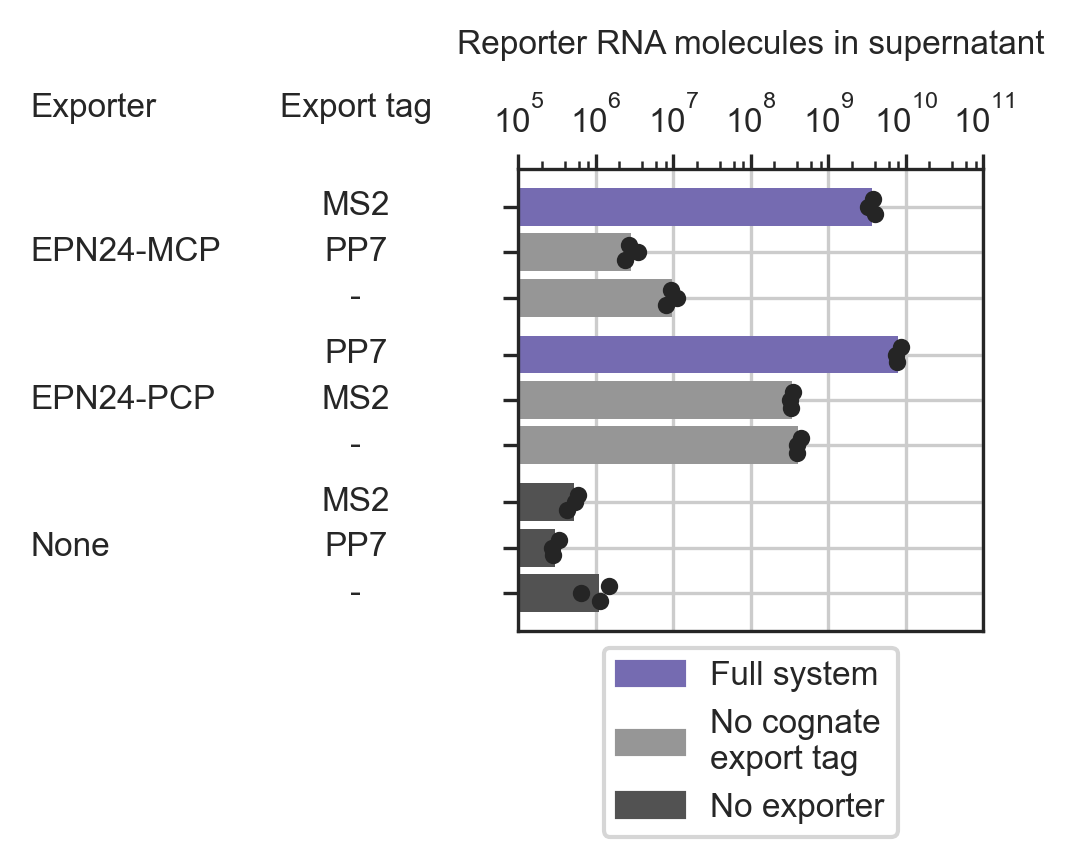

In [20]:
# Make simple plot that shows export using best system and comparison with wild-type Gag

field = "RNA molecules"

sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(2,2))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e5, 1e11)

# Get x positions of bars (numerical data)
x = summary_subset[field]

# Set colors
color = [column_to_color[col] for col in columns_ordered]
# color = ["#756bb1", "#737373", "#31a354", "#737373", "#bdbdbd", "#bdbdbd", "#bdbdbd"]

# Specify custom y positions to group bars
y_origin = 0
y_offset = 0.3
y_space = 0.75

y = [y_origin+1*y_offset, y_origin+3*y_offset, y_origin+5*y_offset,
     y_origin+5*y_offset+y_space, y_origin+7*y_offset+y_space, y_origin+9*y_offset+y_space,
     y_origin+9*y_offset+2*y_space, y_origin+11*y_offset+2*y_space, y_origin+13*y_offset+2*y_space]

# Plot bars showing summary of replicates (mean)
ax.barh(y=y, width=x, color=color, height=0.5, linewidth=0)

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")
x_swarm = data["RNA molecules"]
y_swarm = np.array([y[rank] for rank in data["rank"]])
y_offset3 = np.array([-0.1, 0, 0.1])  # jitter offsets to avoid overlaps
y_offset5 = np.array([-0.15, -0.075, 0, 0.075, 0.15])
y_offset6 = np.array([-0.15, -0.075, -0.025, 0.025, 0.075, 0.15])
y_swarm_offset = y_swarm + np.concatenate([np.tile(y_offset3, 9)])
ax.scatter(x_swarm, y_swarm_offset, color="#252525", s=10, zorder=10)

# Set axis aesthetics
ax.set_ylim(y[0]-0.5, y[-1]+0.5)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA molecules in supernatant", labelpad=10)
ax.set_ylabel("")
ax.set_yticks(y)
ax.grid(True)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set custom tick labels
yticklabels = ""
ax.set_yticklabels(yticklabels, ha="left")

# Set custom tick text annotations
labels_exporter = [column_to_exporter[col] for col in columns_ordered][::3]
y_labels_exporter = [(y[0] + y[1] + y[2])/3, 
                     (y[3] + y[4] + y[5])/3, 
                     (y[6] + y[7] + y[8])/3]

x_pos_text_exporter = 5e-2
x_pos_text_export_tag = 8e2

for label, y_pos in zip(labels_exporter, y_labels_exporter):
    ax.text(x_pos_text_exporter, y_pos, label, ha="left", va="center", size=FONTSIZE)

labels_reporter = [column_to_export_tag[col] for col in columns_ordered]
for label, y_pos in zip(labels_reporter, y):
    ax.text(x_pos_text_export_tag, y_pos, label, ha="center", va="center", size=FONTSIZE)

# Set tick annotation column labels
ax.text(x_pos_text_exporter, y[0]-1.5, "Exporter", ha="left", va="top", size=FONTSIZE)
ax.text(x_pos_text_export_tag, y[0]-1.5, "Export tag", ha="center", va="top", size=FONTSIZE)

# Add legend
color_legend = [color_exporter_engineered,
                color_no_packaging_signal,
                color_no_exporter]
label_legend = ["Full system",
                "No cognate\nexport tag",
                "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]
ax.legend([patches[0], patches[1], patches[2]], label_legend,
          handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
          loc="upper center", bbox_to_anchor=(0.5, 0))

save_figure(fig, "barplot_EPN24_MCP_PCP")